In [65]:
from typing import Any
import numpy as np
from scipy.spatial import cKDTree, Voronoi, ConvexHull, voronoi_plot_2d
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd

def random_in_ellipse(lambdas:np.ndarray|list, size=None, mean_scale=False):
    lambdas = np.asarray(lambdas)
    d, = lambdas.shape
    shape = (1,) if size is None else tuple(np.ravel(size))
    x = np.random.normal(0, 1, size=(*shape, d))
    x = x / np.linalg.norm(x, axis=1)[:,None]
    x = x @ np.diag(lambdas)
    r = np.random.uniform(0, 1, size=shape)**0.5
    if mean_scale:
        r /= (d+1) / (d+2)
    x *= r[:,None]
    return x[0] if size is None else x

def categorical_to_one_hot(X_cat:np.ndarray, d:int|None=None):
    N = len(X_cat)
    d_ = d if d is not None else int(X_cat.max() + 1)
    Y = np.zeros((N, d_))
    Y[np.arange(N), X_cat.astype(int)] = 1
    return Y


(1000, 2)


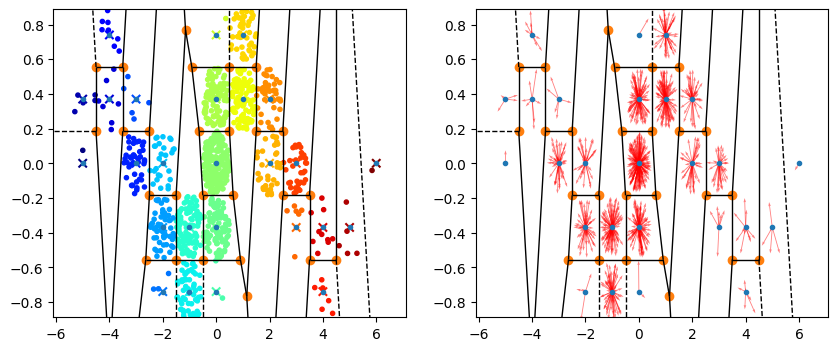

In [67]:


class ColumnGroup:
    def __init__(self, X:np.ndarray):
        X = self.as_2D_array(X)
        # Some noise to ensure the data points are not repeated
        self._noise = np.random.normal(0, 1e-19, X.shape)
        self.X = X + self._noise
        self.d = X.shape[1]
    
    @staticmethod
    def as_2D_array(X):
        X = np.asarray(X)
        while len(X.shape) < 2:
            X = X[:,None]
        assert len(X.shape) == 2, X.shape
        return X

    def undo(self, Y:np.ndarray):
        return Y - self._noise
    
    def undo2D(self, Y:np.ndarray):
        Y = self.undo(Y)
        while len(Y.shape) <2:
            Y = Y[:,None]
        return Y

class DiscreteColumnGroup(ColumnGroup):
    def __init__(self, X:np.ndarray, uniques:np.ndarray|None=None):
        X = self.as_2D_array(X)
        self.X0 = X.copy()
        self.d = X.shape[1]
        if uniques is None:
            uniques = np.unique(X, axis=0)
        tree = cKDTree(uniques)
        self.tree = tree
        self.uniques = uniques
        # Find the smallest radius on each dimension that guarantees to be inside the voronoi cell
        r = [np.diff(sorted(set(uniques[:,i]))).min() / 2 for i in range(self.d)]
        self.noise_radius = np.array(r)
        # Y = X + self.box_noise(len(X))
        Y = X + self.ellipse_noise(len(X))
        self.X = Y

    def undo(self, Y:np.ndarray):
        _, idx = self.tree.query(Y, k=1)
        X = self.uniques[idx]
        return X
    
    def ellipse_noise(self, size=None):
        shape = (1,) if size is None else tuple(np.ravel(size))
        u = np.random.normal(0,1,(*shape, self.d))
        u = u / np.linalg.norm(u, axis=1)[:,None]
        r = np.random.uniform(0, 1, size=shape)**(1/self.d)
        u = u * r[:,None]
        u = u * self.noise_radius
        return u

    def box_noise(self, size=None):
        shape = (1,) if size is None else tuple(np.ravel(size))
        u = 2*np.random.rand(*shape, self.d) - 1
        u = u * self.noise_radius
        return u

class CategoricalColumnGroup(DiscreteColumnGroup):
    def __init__(self, X_cat:np.ndarray, d:int|None=None):
        X = categorical_to_one_hot(X_cat, d=d)
        self.d = d = X.shape[1]
        uniques = np.eye(d)
        super().__init__(X, uniques=uniques)
    
    def undo(self, Y:np.ndarray):
        Y = super().undo(Y)
        return np.argmax(Y, axis=1)



np.random.seed(0)
X = np.random.normal(0, 1, (1000,2))
X[:,1] =  X[:,1] * 0.1 + np.sin(2*X[:,0])
X = (2*X).astype(int).astype(float)
X[:,1] *= 0.37

gr = DiscreteColumnGroup(X)

print(gr.X.shape)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes = axes.ravel()
voronoi_plot_2d(Voronoi(gr.uniques), ax=axes[0])
axes[0].scatter(gr.uniques[:,0], gr.uniques[:,1], c=gr.tree.query(gr.uniques, k=1)[1], cmap='jet', marker='x')
axes[0].scatter(gr.X[:,0], gr.X[:,1], c=gr.tree.query(gr.X, k=1)[1], cmap='jet', marker='.')

voronoi_plot_2d(Voronoi(gr.uniques), ax=axes[1])
axes[1].quiver(gr.X0[:,0], gr.X0[:,1], gr.X[:,0]-gr.X0[:,0], gr.X[:,1]-gr.X0[:,1], angles='xy', scale_units='xy', scale=1, color='r', alpha=0.5)

plt.show()


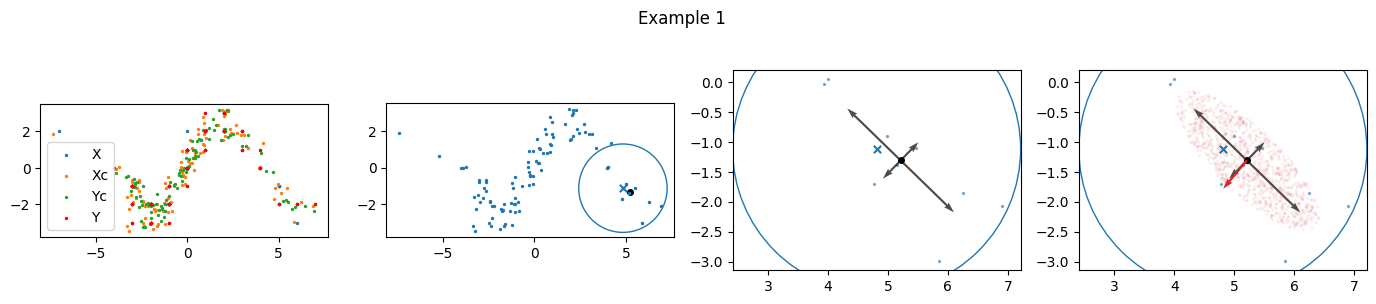

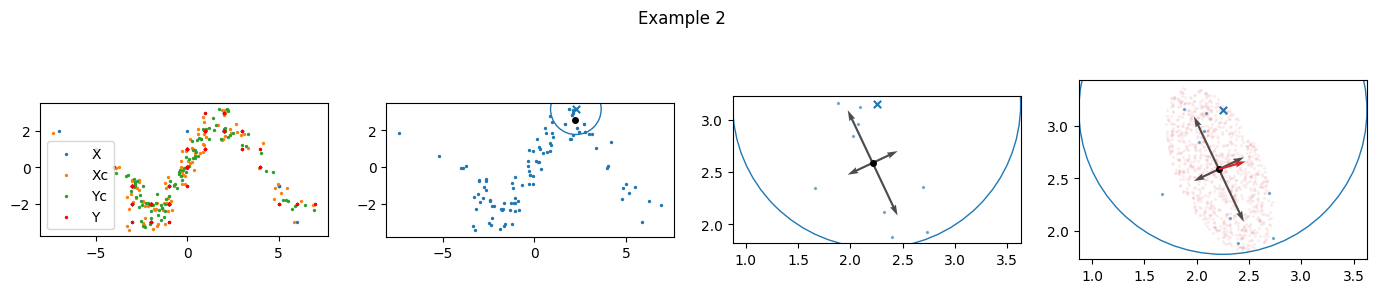

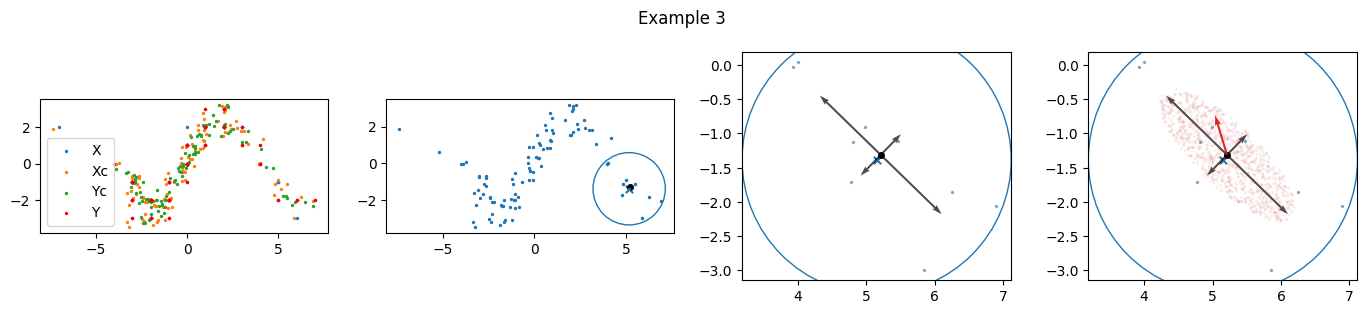

In [68]:

class ColumnTypes:
    def __init__(self,
                 continuous:list[int]=[],
                 categorical:list[list[int]|int]=[],
                 discrete:list[list[int]|int]=[],
        ):
        # flatten
        discrete = [[i] if isinstance(i, int) else i for i in discrete]
        categorical = [[i] if isinstance(i, int) else i for i in categorical]
        idx = [*continuous, *sum(categorical, []), *sum(discrete, [])] # type:ignore
        self.d = len(idx)
        assert set(idx) == set(range(len(idx))), "The continuous, categorical and discrete indices must be unique and cover all columns"
        cols_cont = [ColumnGroup(X[:, idx]) for idx in continuous]
        cols_cat = [CategoricalColumnGroup(X[:, idx]) for idx in categorical]
        cols_disc = [DiscreteColumnGroup(X[:, idx]) for idx in discrete]
        self.column_groups = cols_cont + cols_cat + cols_disc
        self.n_columns_out = self.d + sum(c.d for c in cols_cat) - len(cols_cat)

    def data_pre_post(self, X: np.ndarray):
        _, d = X.shape
        assert d == self.d, (d, self.d)
        pre = np.concatenate([c.X for c in self.column_groups], axis=1)
        def post(Y:np.ndarray):
            return np.concatenate([c.undo2D(Y[:, i:i+c.d]) for i, c in enumerate(self.column_groups)], axis=1)
        return pre, post


min_neigh_radius = 0.2
min_neigh_count = 10
min_abs_noise_radius = 0.2
min_rel_noise_radius = 0.7

def algorithm(X: np.ndarray):
    X = np.asarray(X).astype(float)
    assert np.unique(X, axis=0).shape[0] == X.shape[0], "The data must not have repeated rows. Use ColumnTypes to preprocess the data and get rid of this error"
    mu, sigma = X.mean(axis=0), X.std(axis=0)
    X = (X - mu) / sigma
    N, d = X.shape
    Y = X * np.nan
    # Prepare nearest neighbor search
    tree = cKDTree(X)
    for i_x in range(N):
        xi = X[i_x]
        # Compute neighbors
        r = min_neigh_radius
        idx = tree.query_ball_point(xi, r=r, p=2)
        while len(idx) < min_neigh_count:
            r *= 1.1
            idx = tree.query_ball_point(xi, r=r, p=2)
        x = X[idx].mean(axis=0)
        Nx = X[idx] - x
        # Diagonalize covariance matrix
        cov = np.cov(Nx.T)
        try:
            diag, V = np.linalg.eig(cov)
        except np.linalg.LinAlgError:
            print(cov)
            print(Nx.shape)
            raise
        lambdas = np.sqrt(diag)
        min_noise_radius = max(min_abs_noise_radius, min_rel_noise_radius * r)
        y_lambdas = lambdas * max(1, min_noise_radius/float(np.linalg.norm(lambdas)))
        # Sample a random direction
        y = random_in_ellipse(y_lambdas)
        y = V @ y + x
        Y[i_x] = y
    Y = Y * sigma + mu
    return Y


def algorithm_plot(X: np.ndarray, i_x=None, axes=None):
    X = np.asarray(X).astype(float)
    tree = cKDTree(X)
    N, d = X.shape
    assert d==2
    if i_x is None:
        i_x = np.random.randint(N)
    xi = X[i_x]
    # _, idx = tree.query(xi, k=N_explore, p=2)
    r = min_neigh_radius
    idx = tree.query_ball_point(xi, r=r, p=2)
    while len(idx) < min_neigh_count:
        r *= 1.1
        idx = tree.query_ball_point(xi, r=r, p=2)
    # print(r)
    x = X[idx].mean(axis=0)
    Nx = X[idx] - x
    # Diagonalize covariance matrix
    cov = np.cov(Nx.T)
    diag, V = np.linalg.eig(cov)
    lambdas = np.sqrt(diag)
    plot_radius = np.max(np.linalg.norm(Nx + x - xi, axis=1))* 1.05 
    plot_xlims = xi[0] + plot_radius* np.array([-1, 1])
    AxesType = plt.Axes # type:ignore
    def subset_plot(ax:"AxesType", show=[]):
        features = {k:True for k in show}
        ax.set_aspect('equal')
        if features.get('xi'):
            ax.scatter(xi[None,0], xi[None,1], marker='x', s=28, color='tab:blue')
        if features.get('x'):
            ax.scatter(x[None,0], x[None,1], marker='o', s=16, color='black')
        if features.get('X'):
            ax.scatter(X[:,0], X[:,1], label='X', s=2, color='tab:blue')
        if features.get('circle'):
            radius = np.max(np.linalg.norm(Nx + x - xi, axis=1))* 1.05
            circle = plt.Circle(xi, radius, fill=False, color='tab:blue') # type: ignore
            ax.add_artist(circle)
        if features.get('Nx'):
            ax.scatter(x[0]+Nx[:,0], x[1]+Nx[:,1], label='X', s=2, marker='o', color='tab:blue', alpha=0.5)
        # if features.get('Nxi'):
        #     ax.scatter(xi[0]+Nxi[:,0], xi[1]+Nxi[:,1], label='X', s=5, marker='o', color='tab:blue')
        if features.get('V'):
            for i_v in range(d):
                u = V[:, i_v] * lambdas[i_v]
                ax.quiver(*x, *u, scale=1, scale_units='xy', color='black', alpha=0.7, linewidths=0.5)
                ax.quiver(*x, *-u, scale=1, scale_units='xy', color='black', alpha=0.7, linewidths=0.5)
        if features.get('Y'):
            ax.scatter(Y[:,0], Y[:,1], s=2, c='tab:red', alpha=0.05) # For the plot limits 
            # xx = np.zeros_like(Y)
            # xx[:] = x[None,:]
            # ax.quiver(*xx.T, *(Y-x[None,:]).T, scale=1, scale_units='xy', color='tab:red', alpha=0.2)
        if features.get('Y_contour'):
            kw:Any = dict(fill=False, alpha=0.9, levels=5, linewidths=0.5)
            sns.kdeplot(data=pd.DataFrame(Y), x=0, y=1, ax=ax, color='tab:red', **kw)
        if features.get('y'):
            ax.quiver(*x, *(y-x),  scale=1, scale_units='xy', color='tab:red', alpha=1)
        if features.get('y_mean'):
            ax.quiver(*x, *(y_mean-x),  scale=1, scale_units='xy', color='tab:purple', alpha=1)
        return

    min_noise_radius = max(min_abs_noise_radius, min_rel_noise_radius * r)
    y_lambdas = lambdas * max(1, min_noise_radius/float(np.linalg.norm(lambdas)))
    y = random_in_ellipse(y_lambdas, mean_scale=True)
    y = V @ y + x

    # Do the sampling many times to show a contour plot
    N_samples = 1000
    Y = random_in_ellipse(y_lambdas, size=N_samples)
    Y =  (V @ Y.T).T + x[None, :]
    y_mean = np.mean(Y, axis=0)

    if axes is None:
        fig, axes = plt.subplots(2, 3, figsize=(5, 5))
        axes = axes.flatten()
    subset_plot(axes[0], show='X xi x circle Nx'.split())
    subset_plot(axes[1], show='xi x circle Nx V'.split())
    # axes[1].set_xlim(axes[0].get_xlim())
    axes[1].set_xlim(*plot_xlims)
    subset_plot(axes[2], show='xi x circle Nx V Y y'.split())
    axes[2].set_xlim(*plot_xlims)
    return

# Generate test data
import matplotlib.pyplot as plt

np.random.seed(0)
X = np.random.normal(0, 1, (100,2))
X[:,1] =  X[:,1] * 0.1 + np.sin(2*X[:,0])
X = (3*X).astype(int)

column_types = ColumnTypes(continuous=[], categorical=[], discrete=[[0,1]])
Xc, post = column_types.data_pre_post(X)
Yc = algorithm(Xc)
Y = post(Yc)

for i_x in range(3):
    fig, axes = plt.subplots(1, 4, figsize=(14, 3))
    axes = axes.flatten()
    axes[0].set_aspect('equal')
    axes[0].scatter(X[:,0], X[:,1], label='X', s=2)
    axes[0].scatter(Xc[:,0], Xc[:,1], label='Xc', s=2)
    axes[0].scatter(Yc[:,0], Yc[:,1], label='Yc', s=2, c='tab:green')
    axes[0].scatter(Y[:,0], Y[:,1], label='Y', s=2, c='red')
    axes[0].legend()
    algorithm_plot(Xc, i_x=i_x, axes=axes[1:])
    plt.suptitle(f"Example {i_x+1}")
    plt.tight_layout()
    plt.show()


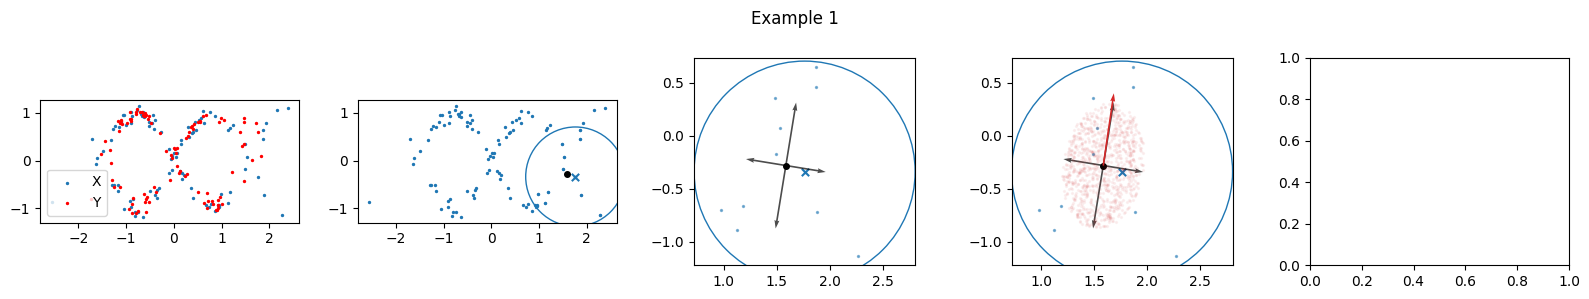

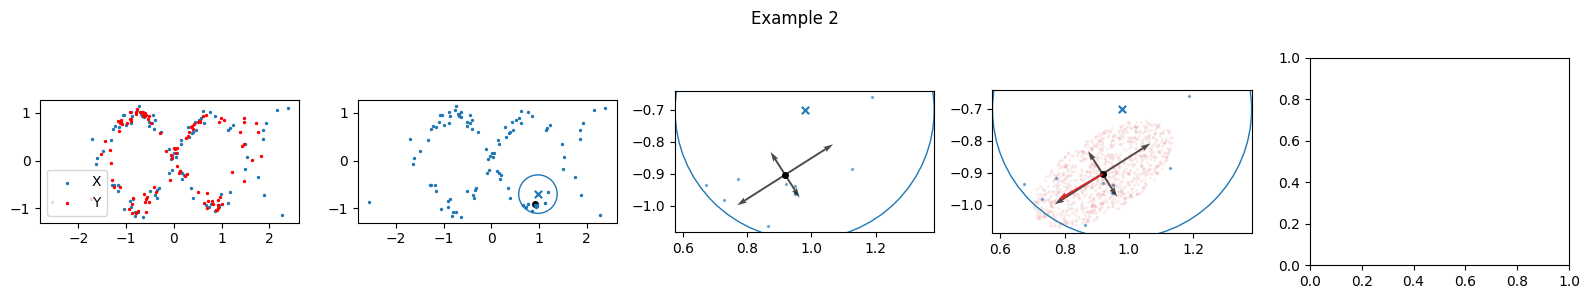

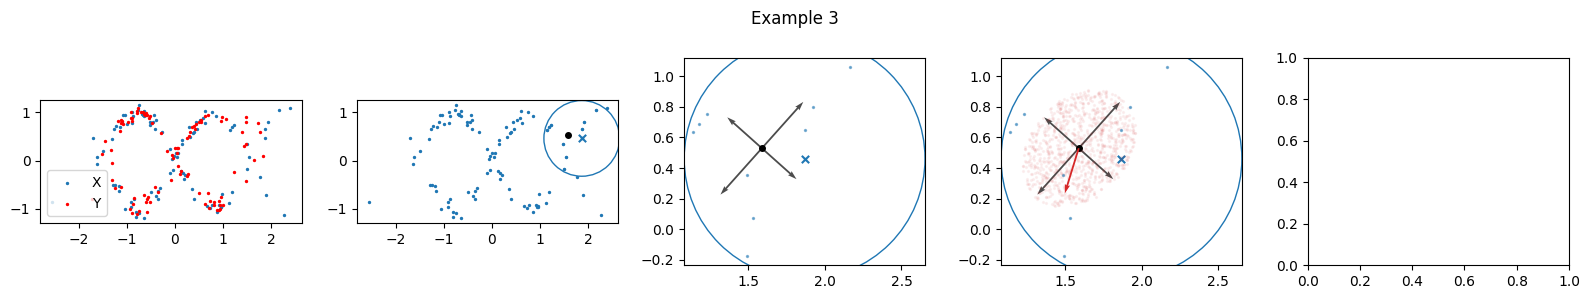

In [69]:

np.random.seed(0)
X = np.random.normal(0, 1, (100,2))
mask = np.random.rand(len(X)) > 0.5
X[mask,1] =  X[mask,1] * 0.1 + np.sin(2*X[mask,0])
mask = ~mask
X[mask,1] =  X[mask,1] * 0.1 - np.sin(2*X[mask,0])
column_types = ColumnTypes(continuous=[0,1], categorical=[], discrete=[])
Xc, post = column_types.data_pre_post(X)
Yc = algorithm(Xc)
Y = post(Yc)

for i_x in range(3):
    fig, axes = plt.subplots(1, 5, figsize=(16, 3))
    axes = axes.flatten()
    axes[0].set_aspect('equal')
    axes[0].scatter(Xc[:,0], Xc[:,1], label='X', s=2)
    axes[0].scatter(Yc[:,0], Yc[:,1], label='Y', s=2, c='red')
    axes[0].legend()
    algorithm_plot(Xc, i_x=i_x, axes=axes[1:])
    plt.suptitle(f"Example {i_x+1}")
    plt.tight_layout()
    plt.show()

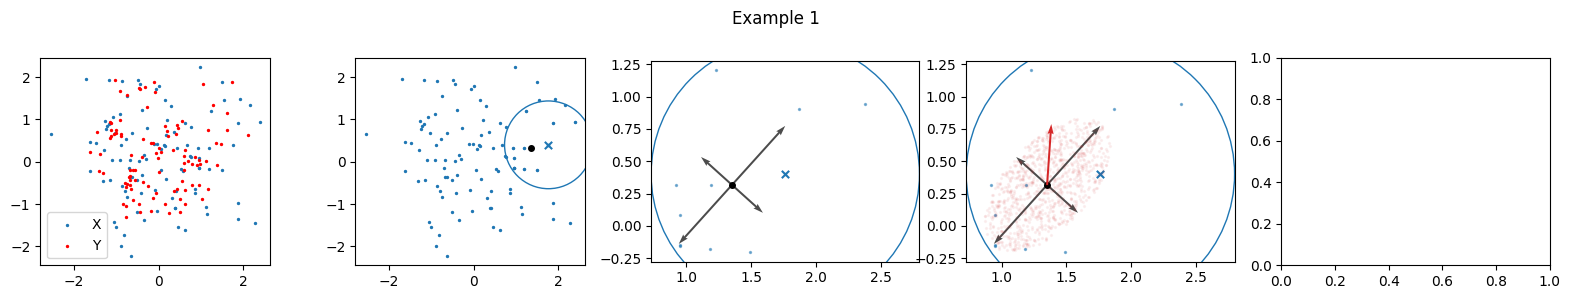

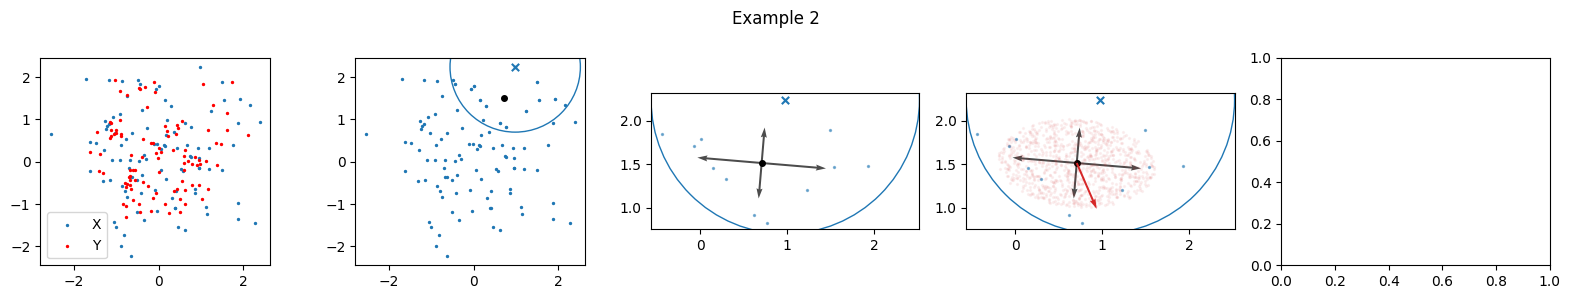

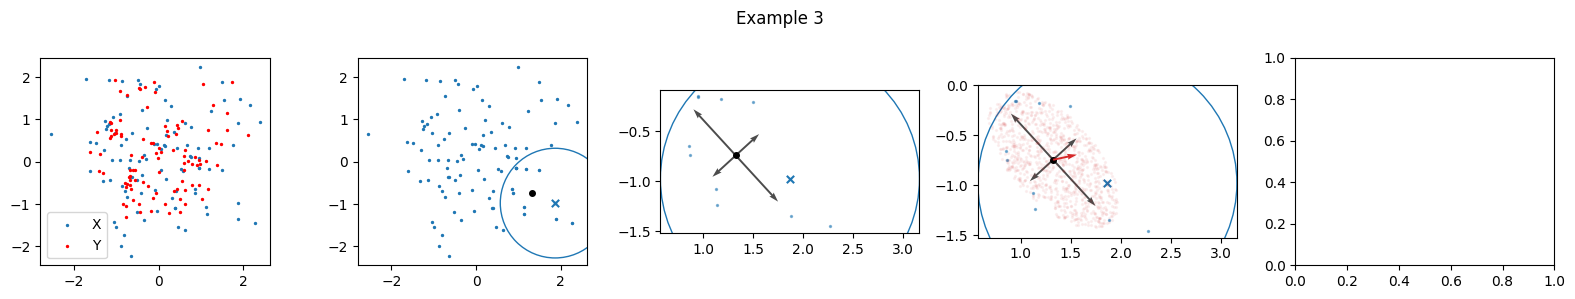

In [70]:

np.random.seed(0)
X = np.random.normal(0, 1, (100,2))
Y = algorithm(X)

for i_x in range(3):
    fig, axes = plt.subplots(1, 5, figsize=(16, 3))
    axes = axes.flatten()
    axes[0].set_aspect('equal')
    axes[0].scatter(X[:,0], X[:,1], label='X', s=2)
    axes[0].scatter(Y[:,0], Y[:,1], label='Y', s=2, c='red')
    axes[0].legend()
    algorithm_plot(X, i_x=i_x, axes=axes[1:])
    plt.suptitle(f"Example {i_x+1}")
    plt.tight_layout()
    plt.show()

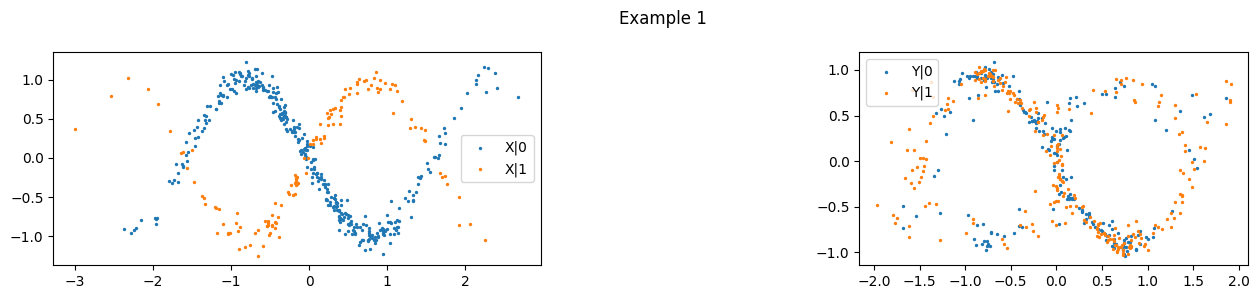

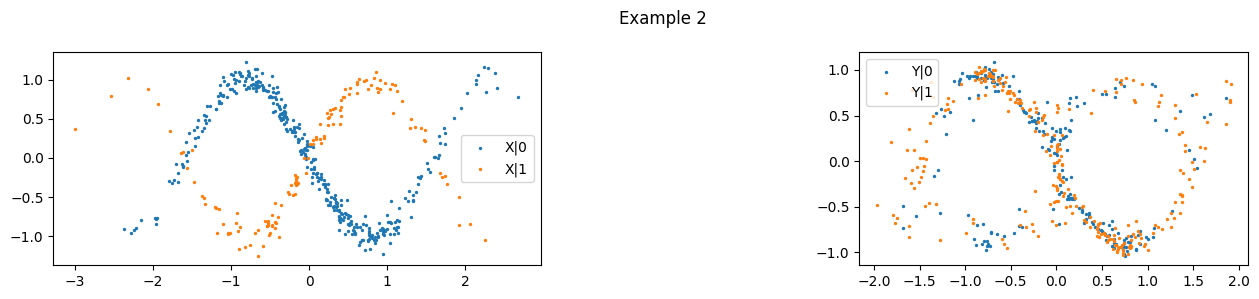

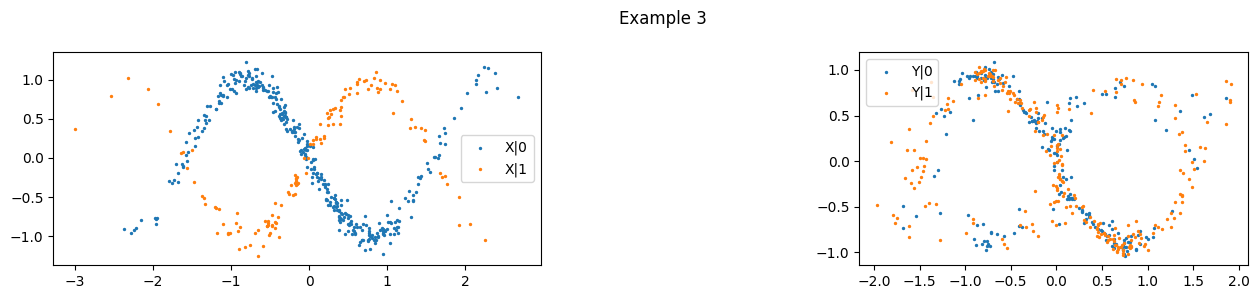

In [77]:

np.random.seed(0)
X = np.random.normal(0, 1, (500,3))
X[:,2] =  X[:,2] > 0.5
mask = X[:,2] == 1
X[mask,1] =  X[mask,1] * 0.1 + np.sin(2*X[mask,0])
mask = ~mask
X[mask,1] =  X[mask,1] * 0.1 - np.sin(2*X[mask,0])
column_types = ColumnTypes(continuous=[0,1], categorical=[2], discrete=[])
Xc, post = column_types.data_pre_post(X)
Yc = algorithm(Xc)
Y = post(Yc)

for i_x in range(3):
    fig, axes = plt.subplots(1, 2, figsize=(16, 3))
    axes = axes.flatten()
    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')
    axes[0].scatter(X[X[:,2]==0,0], X[X[:,2]==0,1], label='X|0', s=2)
    axes[0].scatter(X[X[:,2]==1,0], X[X[:,2]==1,1], label='X|1', s=2)
    axes[1].scatter(Y[Y[:,2]==0,0], Y[Y[:,2]==0,1], label='Y|0', s=2)
    axes[1].scatter(Y[Y[:,2]==1,0], Y[Y[:,2]==1,1], label='Y|1', s=2)
    axes[0].legend()
    axes[1].legend()
    # algorithm_plot(Xc, i_x=i_x, axes=axes[1:])
    plt.suptitle(f"Example {i_x+1}")
    plt.tight_layout()
    plt.show()